In [1]:
%%capture
!pip install /kaggle/input/torch-geometric/torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl
!pip install /kaggle/input/torch-geometric/torch_sparse-0.6.18-cp310-cp310-linux_x86_64.whl
!pip install torch-geometric

In [2]:
import os
import copy
import torch
import warnings
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from torch_geometric.utils import to_networkx
from torch_geometric.data import Data, DataLoader

import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d
from torch_geometric.nn import GATv2Conv

from types import SimpleNamespace

warnings.filterwarnings('ignore')

In [3]:
df_features = pd.read_csv("/content/drive/MyDrive/Elliptic/elliptic_bitcoin_dataset/elliptic_txs_features.csv", header=None)
df_edges = pd.read_csv("/content/drive/MyDrive/Elliptic/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
df_classes =  pd.read_csv("/content/drive/MyDrive/Elliptic/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
df_classes['class'] = df_classes['class'].map({'unknown': 2, '1': 1, '2': 0})

In [4]:
# nodes features
df_features.head()

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [5]:
df_edges.head()

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206


In [6]:
df_classes.head()

,txId,class
0,230425980,2
1,5530458,2
2,232022460,2
3,232438397,0
4,230460314,2


In [7]:
df_classes['class'].value_counts()

,count
class,
2,157205
0,42019
1,4545


In [8]:
# merging node features DF with classes DF
df_merge = df_features.merge(df_classes, how='left', right_on="txId", left_on=0)
df_merge = df_merge.sort_values(0).reset_index(drop=True)

In [9]:
# mapping nodes to indices
nodes = df_merge[0].values
map_id = {j:i for i,j in enumerate(nodes)}

# mapping edges to indices
edges = df_edges.copy()
edges.txId1 = edges.txId1.map(map_id)
edges.txId2 = edges.txId2.map(map_id)
edges = edges.astype(int)

edge_index = np.array(edges.values).T
edge_index = torch.tensor(edge_index, dtype=torch.long).contiguous()

# weights for the edges are equal in case of model without attention
weights = torch.tensor([1] * edge_index.shape[1] , dtype=torch.float32)

print("Total amount of edges in DAG:", edge_index.shape)

Total amount of edges in DAG: torch.Size([2, 234355])


In [10]:
# maping node ids to corresponding indexes
node_features = df_merge.drop(['txId'], axis=1).copy()
node_features[0] = node_features[0].map(map_id)

# store known and unknown nodes
classified_idx = node_features['class'].loc[node_features['class'] != 2].index
unclassified_idx = node_features['class'].loc[node_features['class'] == 2].index

# replace unkown class with 0, to avoid having 3 classes, this data/labels never used in training
node_features['class'] = node_features['class'].replace(2, 0)

labels = node_features['class'].values

# drop indeces, class and temporal axes
node_features = torch.tensor(np.array(node_features.drop([0, 'class', 1], axis=1).values, dtype=np.float32), dtype=torch.float32)

In [11]:
# converting data to PyGeometric graph data format
elliptic_dataset = Data(x = node_features,
                        edge_index = edge_index,
                        edge_attr = weights,
                        y = torch.tensor(labels, dtype=torch.float32))

print(f'Number of nodes: {elliptic_dataset.num_nodes}')
print(f'Number of node features: {elliptic_dataset.num_features}')
print(f'Number of edges: {elliptic_dataset.num_edges}')
print(f'Number of edge features: {elliptic_dataset.num_features}')
print(f'Average node degree: {elliptic_dataset.num_edges / elliptic_dataset.num_nodes:.2f}')
print(f'Number of classes: {len(np.unique(elliptic_dataset.y))}')
print(f'Has isolated nodes: {elliptic_dataset.has_isolated_nodes()}')
print(f'Has self loops: {elliptic_dataset.has_self_loops()}')
print(f'Is directed: {elliptic_dataset.is_directed()}')

Number of nodes: 203769
Number of node features: 165
Number of edges: 234355
Number of edge features: 165
Average node degree: 1.15
Number of classes: 2
Has isolated nodes: False
Has self loops: False
Is directed: True


In [12]:
config = SimpleNamespace(seed = 0,
                         learning_rate = 0.001,
                         weight_decay = 1e-5,
                         input_dim = 165,
                         output_dim = 1,
                         hidden_size = 128,
                         num_epochs = 400,
                         checkpoints_dir = './models/elliptic_gnn',
                         device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

print("Using device:", config.device)

Using device: cuda


In [13]:
y_train = labels[classified_idx]

# spliting train set and validation set
_, _, _, _, train_idx, valid_idx = train_test_split(node_features[classified_idx],
                                                    y_train,
                                                    classified_idx,
                                                    test_size=0.15,
                                                    random_state=config.seed,
                                                    stratify=y_train)

elliptic_dataset.train_idx = torch.tensor(train_idx, dtype=torch.long)
elliptic_dataset.val_idx = torch.tensor(valid_idx, dtype=torch.long)
elliptic_dataset.test_idx = torch.tensor(unclassified_idx, dtype=torch.long)

print("Train dataset size:", elliptic_dataset.train_idx.shape[0])
print("Validation dataset size:", elliptic_dataset.val_idx.shape[0])
print("Test dataset size:", elliptic_dataset.test_idx.shape[0])

Train dataset size: 39579
Validation dataset size: 6985
Test dataset size: 157205


In [14]:
class GAT(torch.nn.Module):
    """Graph Attention Network"""
    def __init__(self, dim_in, dim_h, dim_out, heads=8):
        super(GAT, self).__init__()
        self.norm1 = BatchNorm1d(dim_in)
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads,
                              dropout=0.3)
        self.norm2 = BatchNorm1d(dim_h*heads)
        self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=heads,
                              concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        h = self.norm1(x)
        h = self.gat1(h, edge_index)
        h = self.norm2(h)
        h = F.leaky_relu(h)
        out = self.gat2(h, edge_index)
        return out

def accuracy(y_pred, y_test, prediction_threshold=0.5):
    y_pred_label = (torch.sigmoid(y_pred) > prediction_threshold).float()

    correct_results_sum = (y_pred_label == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]

    return acc

In [15]:
def train_evaluate(model, data, criterion, optimizer, *args):
    num_epochs = args[0]
    checkpoints_dir = args[1]
    model_filename = args[2]

    best_model_wts = copy.deepcopy(model.state_dict())

    best_loss = float('inf')

    if not os.path.exists(checkpoints_dir):
        os.makedirs(checkpoints_dir)

    model.train()
    for epoch in range(num_epochs+1):
        # Training
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_idx], data.y[data.train_idx].unsqueeze(1))
        acc = accuracy(out[data.train_idx], data.y[data.train_idx].unsqueeze(1), prediction_threshold=0.5)
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_idx], data.y[data.val_idx].unsqueeze(1))
        val_acc = accuracy(out[data.val_idx], data.y[data.val_idx].unsqueeze(1), prediction_threshold=0.5)

        if epoch % 10 == 0:
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.4f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

            if val_loss < best_loss:
                best_loss = val_loss
                print("Saving model for best loss")
                checkpoint = {'state_dict': best_model_wts}
                torch.save(checkpoint, os.path.join(checkpoints_dir, model_filename))
                best_model_wts = copy.deepcopy(model.state_dict())

    return model

def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    preds = ((torch.sigmoid(out) > 0.5).float()*1).squeeze(1)
    return preds

In [16]:
torch.manual_seed(config.seed)

gat_model = GAT(config.input_dim, config.hidden_size, config.output_dim).to(config.device)
data_train = elliptic_dataset.to(config.device)

optimizer = torch.optim.Adam(gat_model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
criterion = torch.nn.BCEWithLogitsLoss()

train_evaluate(gat_model,
               data_train,
               criterion,
               optimizer,
               config.num_epochs,
               config.checkpoints_dir,
               'gat_best_model.pth.tar')

Epoch   0 | Train Loss: 0.761 | Train Acc:  49.94% | Val Loss: 0.7537 | Val Acc: 51.14%
Saving model for best loss
Epoch  10 | Train Loss: 0.246 | Train Acc:  90.47% | Val Loss: 0.2445 | Val Acc: 90.44%
Saving model for best loss
Epoch  20 | Train Loss: 0.221 | Train Acc:  91.39% | Val Loss: 0.2199 | Val Acc: 91.54%
Saving model for best loss
Epoch  30 | Train Loss: 0.201 | Train Acc:  92.76% | Val Loss: 0.1979 | Val Acc: 92.71%
Saving model for best loss
Epoch  40 | Train Loss: 0.186 | Train Acc:  93.70% | Val Loss: 0.1857 | Val Acc: 93.47%
Saving model for best loss
Epoch  50 | Train Loss: 0.172 | Train Acc:  94.33% | Val Loss: 0.1765 | Val Acc: 94.14%
Saving model for best loss
Epoch  60 | Train Loss: 0.163 | Train Acc:  94.82% | Val Loss: 0.1652 | Val Acc: 94.70%
Saving model for best loss
Epoch  70 | Train Loss: 0.153 | Train Acc:  95.26% | Val Loss: 0.1564 | Val Acc: 95.18%
Saving model for best loss
Epoch  80 | Train Loss: 0.147 | Train Acc:  95.67% | Val Loss: 0.1492 | Val Acc:

GAT(
  (norm1): BatchNorm1d(165, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gat1): GATv2Conv(165, 128, heads=8)
  (norm2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gat2): GATv2Conv(1024, 1, heads=8)
)

In [17]:
import torch

# Save the GNN model's state_dict (weights and biases)
gnn_model_path = '/content/elliptic_gnn_model.pth'
torch.save(gat_model.state_dict(), gnn_model_path)

print(f'GNN model saved to {gnn_model_path}')


GNN model saved to /content/elliptic_gnn_model.pth


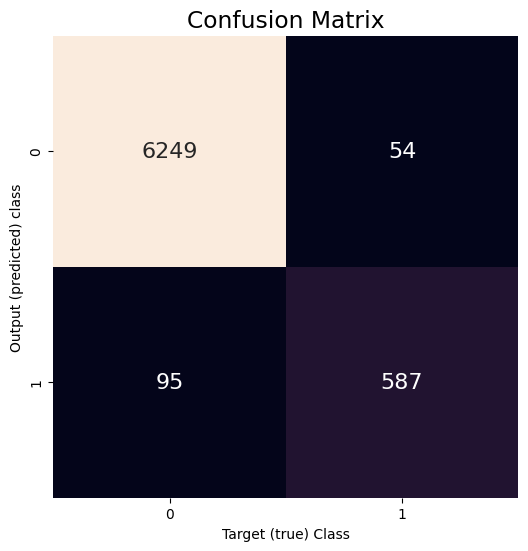

              precision    recall  f1-score   support

       licit       0.99      0.99      0.99      6303
     illicit       0.92      0.86      0.89       682

    accuracy                           0.98      6985
   macro avg       0.95      0.93      0.94      6985
weighted avg       0.98      0.98      0.98      6985



In [18]:
gat_model.load_state_dict(torch.load(os.path.join(config.checkpoints_dir, 'gat_best_model.pth.tar'))['state_dict'])

y_test_preds = test(gat_model, data_train)

# confusion matrix on validation data
conf_mat = confusion_matrix(data_train.y[data_train.val_idx].detach().cpu().numpy(), y_test_preds[valid_idx].cpu())

plt.subplots(figsize=(6,6))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat, annot=True, fmt=".0f", annot_kws={"size": 16}, cbar=False)
plt.xlabel('Target (true) Class'); plt.ylabel('Output (predicted) class'); plt.title('Confusion Matrix')
plt.show();

print(classification_report(data_train.y[data_train.val_idx].detach().cpu().numpy(),
                            y_test_preds[valid_idx].cpu(),
                            target_names=['licit', 'illicit']))

In [19]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import precision_score, recall_score, f1_score
import torch

In [20]:
def get_node_embeddings(model, data):
    model.eval()
    with torch.no_grad():
        embeddings = model(data.x, data.edge_index).cpu().numpy()
    return embeddings

In [21]:
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

class AnomalyDetection:
    def __init__(self, embeddings, contamination_rate=None):
        self.embeddings = embeddings

        # Ensure contamination is valid (between 0.0 and 0.5)
        if contamination_rate is None:
            estimated_contamination = max(0.01, min(0.1, abs(np.mean(embeddings))))  # Ensure valid range
        else:
            estimated_contamination = max(0.01, min(0.5, contamination_rate))  # Clamp value to (0, 0.5]

        self.contamination_rate = estimated_contamination

        self.isolation_forest = IsolationForest(
            n_estimators=300,
            contamination=self.contamination_rate,
            max_samples=min(5000, len(embeddings)),
            random_state=42
        )

        self.lof = LocalOutlierFactor(
            n_neighbors=25,
            contamination=self.contamination_rate,
            novelty=True
        )

    def train_models(self):
        self.isolation_forest.fit(self.embeddings)
        self.lof.fit(self.embeddings)

    def predict_anomalies(self):
        iso_preds = self.isolation_forest.predict(self.embeddings)
        lof_preds = self.lof.predict(self.embeddings)

        # Convert {1: normal, -1: anomaly} to {0: normal, 1: fraud}
        iso_preds = np.where(iso_preds == -1, 1, 0)
        lof_preds = np.where(lof_preds == -1, 1, 0)

        return iso_preds, lof_preds


In [22]:
embeddings = get_node_embeddings(gat_model, data_train)

In [23]:
# Apply Anomaly Detection
anomaly_detector = AnomalyDetection(embeddings)
anomaly_detector.train_models()
iso_preds, lof_preds = anomaly_detector.predict_anomalies()

In [24]:
y_true = data_train.y[data_train.val_idx].detach().cpu().numpy()

In [25]:
from sklearn.ensemble import IsolationForest

# Train the Isolation Forest model
iso_forest_model = IsolationForest(n_estimators=100, contamination=0.1)  # Example hyperparameters
iso_forest_model.fit(embeddings)  # Assuming embeddings are already obtained from the GNN

# Save the trained Isolation Forest model
iso_forest_model_path = '/content/iso_forest_model.pkl'
import joblib
joblib.dump(iso_forest_model, iso_forest_model_path)

print(f'Isolation Forest model saved to {iso_forest_model_path}')


Isolation Forest model saved to /content/iso_forest_model.pkl


In [ ]:
print("\n--- Isolation Forest ---")
print("Precision:", precision_score(y_true, [iso_preds[i] for i in valid_idx]))
print("Recall:", recall_score(y_true, [iso_preds[i] for i in valid_idx]))
print("F1 Score:", f1_score(y_true, [iso_preds[i] for i in valid_idx]))


--- Isolation Forest ---
Precision: 0.2708095781071836
Recall: 0.6964809384164223
F1 Score: 0.3899835796387521


In [ ]:
print("\n--- Local Outlier Factor ---")
print("Precision:", precision_score(y_true, [lof_preds[i] for i in valid_idx]))
print("Recall:", recall_score(y_true, [lof_preds[i] for i in valid_idx]))
print("F1 Score:", f1_score(y_true, [lof_preds[i] for i in valid_idx]))


--- Local Outlier Factor ---
Precision: 0.10067114093959731
Recall: 0.08797653958944282
F1 Score: 0.09389671361502347


In [26]:
from sklearn.ensemble import IsolationForest

# Sample dataset
X = [
    [5, 1, 0],       # T1
    [200, 45, 1],    # T2
    [15, 5, 0],      # T3
    [10000, 500, 1], # T4
    [8, 2, 0],       # T5
]

# Train Isolation Forest
iso_forest = IsolationForest(contamination=0.2, random_state=42)
iso_forest.fit(X)

# Predict anomalies
predictions = iso_forest.predict(X)
fraud_labels = ["Fraud" if x == -1 else "Non-Fraud" for x in predictions]

# Display results
for i, label in enumerate(fraud_labels):
    print(f"Transaction {i+1}: {label}")


Transaction 1: Non-Fraud
Transaction 2: Non-Fraud
Transaction 3: Non-Fraud
Transaction 4: Fraud
Transaction 5: Non-Fraud


In [ ]:
from sklearn.neighbors import LocalOutlierFactor

# Sample dataset
X = [
    [5, 1, 0],       # T1
    [200, 45, 1],    # T2
    [15, 5, 0],      # T3
    [10000, 500, 1], # T4
    [8, 2, 0],       # T5
]

# Train LOF model
lof = LocalOutlierFactor(n_neighbors=2, contamination=0.2)
predictions = lof.fit_predict(X)

# Convert LOF predictions to fraud labels
fraud_labels = ["Fraud" if x == -1 else "Non-Fraud" for x in predictions]

# Display results
for i, label in enumerate(fraud_labels):
    print(f"Transaction {i+1}: {label}")


Transaction 1: Non-Fraud
Transaction 2: Non-Fraud
Transaction 3: Non-Fraud
Transaction 4: Fraud
Transaction 5: Non-Fraud


In [27]:
# Predict fraud on test dataset
test_embeddings = embeddings[data_train.test_idx.cpu().numpy()]  # Move test indices to CPU before indexing
test_iso_preds = [1 if x == -1 else 0 for x in anomaly_detector.isolation_forest.predict(test_embeddings)]


In [28]:
# Predict fraud on test dataset
test_embeddings = embeddings[data_train.test_idx.cpu().numpy()]  # Move test indices to CPU before indexing

# Get predictions and select first 10 examples
test_iso_preds = ["Fraud" if x == -1 else "Non-Fraud" for x in anomaly_detector.isolation_forest.predict(test_embeddings)][:10]


# Print the 10 examples
print("Isolation Forest Predictions (10 examples):", test_iso_preds)



Isolation Forest Predictions (10 examples): ['Non-Fraud', 'Non-Fraud', 'Fraud', 'Fraud', 'Non-Fraud', 'Non-Fraud', 'Non-Fraud', 'Non-Fraud', 'Non-Fraud', 'Non-Fraud']


In [ ]:
from google.colab import files

# Download the saved models
files.download('/content/elliptic_gnn_model.pth')
files.download('/content/iso_forest_model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Reload the GNN model (initializing the model first)
gat_model = GAT(config.input_dim, config.hidden_size, config.output_dim).to(config.device)
gat_model.load_state_dict(torch.load('/content/elliptic_gnn_model.pth'))

# Ensure the model is in evaluation mode
gat_model.eval()


GAT(
  (norm1): BatchNorm1d(165, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gat1): GATv2Conv(165, 128, heads=8)
  (norm2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gat2): GATv2Conv(1024, 1, heads=8)
)

In [ ]:
import joblib

# Reload the Isolation Forest model
iso_forest_model = joblib.load('/content/iso_forest_model.pkl')


In [29]:
def get_node_embeddings(model, data):
    model.eval()
    with torch.no_grad():
        embeddings = model(data.x, data.edge_index).cpu().numpy()  # Get node embeddings
    return embeddings

embeddings = get_node_embeddings(gat_model, data_train)


In [30]:
# Use Isolation Forest to predict anomalies on the GNN-generated embeddings
iso_preds = iso_forest_model.predict(embeddings)

# Convert the predictions into "fraud" (anomaly) or "non-fraud"
iso_preds = ["Fraud" if x == -1 else "Non-Fraud" for x in iso_preds]

# Print results
for i, label in enumerate(iso_preds[:10]):  # Example for first 10 predictions
    print(f"Node {i+1}: {label}")


Node 1: Non-Fraud
Node 2: Non-Fraud
Node 3: Fraud
Node 4: Non-Fraud
Node 5: Fraud
Node 6: Fraud
Node 7: Non-Fraud
Node 8: Fraud
Node 9: Fraud
Node 10: Non-Fraud
